In [1]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv

from IPython.display import Image
from scipy import optimize

from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif, plot_forces, quick_edge_draw  # noqa
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')



C++ extension are not available for this version
collision solver could not be imported You may need to install CGAL and re-install tyssue


In [16]:
def create_frames(
    history,
    output,
    num_frames=None,
    interval=None,
    draw_func=None,
    margin=5,
    **draw_kwds,
):
    """Creates a set of png frames of the recorded history.
   
    Parameters
    ----------
    history : a :class:`tyssue.History` object
    output : path to the output directory
    num_frames : int, the number of frames in the gif
    interval : tuples, define begin and end frame of the gif
    draw_func : a drawing function
         this function must take a `sheet` object as first argument
         and return a `fig, ax` pair. Defaults to quick_edge_draw
         (aka sheet_view with quick mode)
    margin : int, the graph margins in percents, default 5
         if margin is -1, let the draw function decide
    **draw_kwds are passed to the drawing function
    """
    if draw_func is None:
        if draw_kwds.get("mode") in ("quick", None):
            draw_func = quick_edge_draw
        else:
            draw_func = sheet_view

    graph_dir = pathlib.Path(output)
    graph_dir.mkdir(parents=True, exist_ok=True)

    x, y = coords = draw_kwds.get("coords", history.sheet.coords[:2])
    sheet0 = history.retrieve(0)
    bounds = sheet0.vert_df[coords].describe().loc[["min", "max"]]
    delta = (bounds.loc["max"] - bounds.loc["min"]).max()
    margin = delta * margin / 100
    xlim = bounds.loc["min", x] - margin, bounds.loc["max", x] + margin
    ylim = bounds.loc["min", y] - margin, bounds.loc["max", y] + margin

    if interval is None:
        start, stop = None, None
    else:
        start, stop = interval[0], interval[1]

    for i, (t, sheet) in enumerate(History.time_stamps(start, stop, num_frames)):
        try:
            fig, ax = draw_func(sheet, **draw_kwds)
        except Exception as e:
            print("Droped frame {i}")

        if isinstance(ax, plt.Axes) and margin >= 0:
            ax.set(xlim=xlim, ylim=ylim)
        fig.savefig(graph_dir / f"movie_{i:04d}.png")
        plt.close(fig)

In [3]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    for edge in range(len(cellmap.edge_df)):
        FRCnewValue = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECMnewValue = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRCnewValue + ECMnewValue

        return cellmap


In [4]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [5]:
def change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought, endTime):
    
    
    cellmap_original = length_elasticity_range(cellmap_original, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    cellmap_original = prefered_area_range(cellmap_original, lower_prefered_area, higher_prefered_area)


    
    cellmap_original.face_df["face_elasticity"] = face_elasticity
    cellmap_original.edge_df["prefered_length"] = line_nought

    cellmap_original.vert_df["viscosity"] = 1   
    
    cellmap_original.face_df["prefered_area"][40] = 2
    
    

    solver1 = EulerSolver(cellmap_original, geom_original, model_original, history=history_original, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05)
    
    
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

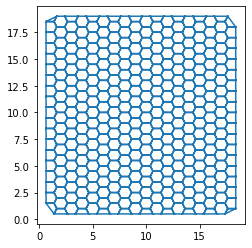

In [6]:
## Definition of the sheet
geom_original  = SheetGeometry 
model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

cellmap_original = Sheet.planar_sheet_3d('cellmap', 10, 10, 1, 1) # This may need to change

history_original = History(cellmap_original, extra_cols={"edge":["dx", "dy"]})


cellmap_original.sanitize ( trim_borders=True, order_edges=True )

geom.update_all(cellmap_original)

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')

In [7]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity = 0.05, lower_prefered_area = 5000, higher_prefered_area = 6000, 
                                                       FRC_lower_length_elasticity = 10, FRC_higher_length_elasticity = 5000, ECM_lower_length_elasticity = 1, 
                                                       ECM_higher_length_elasticity = 100, line_nought = 0.2 , endTime = 10)

In [10]:
time_two = history_original.retrieve(100000000000000)
fig, ax = sheet_view(time_two, ['y', 'x'], mode='quick')

In [ ]:
retrieve_columns(face, area)

In [ ]:
import logging
import os

create_frames(history_original, '/Users/v_lachina/Desktop/Yanlan Mao/output', num_frames=10/0.05,interval=None)